# Demo 4: inferring parameters of the Poisson-EI model
Putting everything together!

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
plt.style.use('./matplotlibrc_notebook')
from scipy import signal
from neurodsp import sim
import fooof
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

### Setting some constants.

In [16]:
# Settings for simulation time.
n_seconds = 60
fs = 1000
t_ker=1.
t = np.arange(0,n_seconds, 1/fs)

# Simulation constants
V_rest = -65
V_rev_E = 0
V_rev_I = -80
n_neurons_E = 8000
n_neurons_I = 2000
firing_rate_E = 2
firing_rate_I = 5

# Welch params
nperseg_ratio = 2
noverlap_ratio = 0.5
nperseg = int(nperseg_ratio*fs)
noverlap = int(nperseg*noverlap_ratio)

### Defining a prior.

In [79]:
prior_bounds = torch.Tensor([
    [0.0001,0.0004], # tau_r_E
    [0.0004, 0.005], # tau_d_E
    [0.0002,0.001], # tau_r_I
    [0.005,0.02], # tau_d_E
    [0.5, 8], # EI_ratio    
])

prior = utils.BoxUniform(low=prior_bounds[:,0], high=prior_bounds[:,1])

### Functions for simulation and analysis.

In [179]:
def simulate_ei(params):
    e_params = params[:2]
    i_params = params[2:4]
    ie_ratio = params[4]
    epsc = sim.sim_synaptic_current(n_seconds, fs, n_neurons_E, firing_rate_E, e_params[0], e_params[1], t_ker) * (V_rest-V_rev_E)
    ipsc = sim.sim_synaptic_current(n_seconds, fs, n_neurons_I, firing_rate_I, i_params[0], i_params[1], t_ker) * (V_rest-V_rev_I)*ie_ratio
    # add components to make LFP
    lfp = epsc + ipsc
    return lfp

def fooof_and_extract(freqs, psds):
    fg = fooof.FOOOFGroup(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
    fg.fit(freqs, psds, freq_range=[0.5,300])
    # Extract FOOOF fits.
    ap_fits = fg.get_params('aperiodic_params')
    f_knee = fooof.utils.params.compute_knee_frequency(ap_fits[:,1], ap_fits[:,2])
    timescale = 1/(f_knee*2*np.pi)
    ap_fits[:,1] = np.log10(timescale)
    errors = fg.get_params('error')
    # Put together as data for training.
    return np.hstack((ap_fits, errors[:,None]))

feature_names = ['offset', 'log10-timescale', 'exponent', 'error']

# Draw prior samples, simulate, and compute summary stats.

In [180]:
num_training = 1000
# Draw prior samples.
theta = prior.sample((num_training,))
# Simulate LFPs
lfps = np.array([simulate_ei(th) for th in theta.numpy()])
# Compute PSDs
freqs, psds = signal.welch(lfps, fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
# FOOOF and extract fits.
x = torch.Tensor(fooof_and_extract(freqs, psds))

Running FOOOFGroup across 1000 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/rdgao/miniconda3/envs/partypack/lib/python3.8/site-packages/fooof/utils/params.py:24: RuntimeWarning: invalid value encountered in power
  return knee ** (1./exponent)


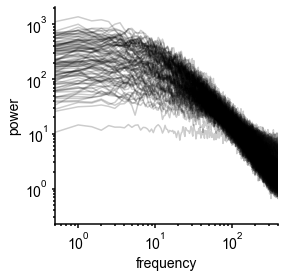

In [181]:
plt.loglog(freqs, psds[:100].T, 'k', alpha=0.2);
plt.xlim([0.5,400])
plt.xlabel('frequency'); plt.ylabel('power'); 

### Plot correlation between parameter and data feature.

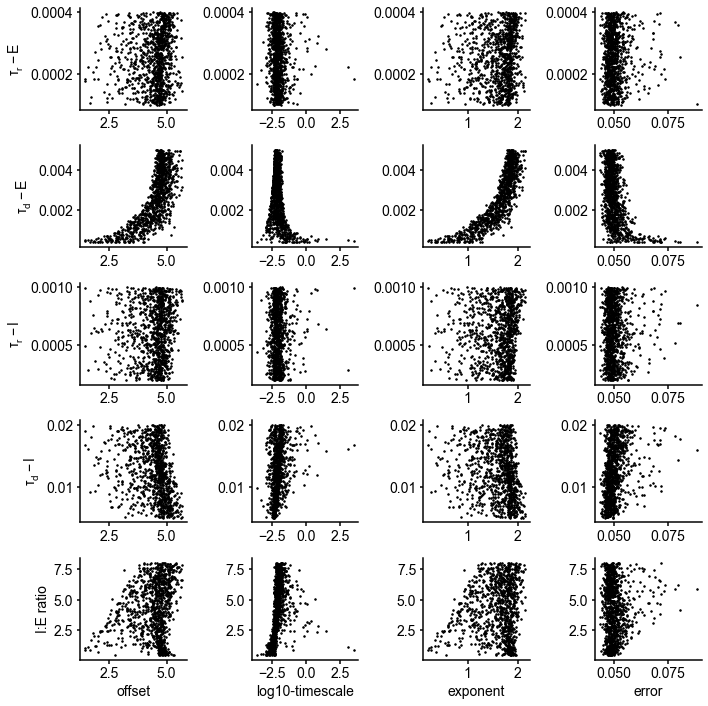

In [185]:
plt.figure(figsize=(2.5*4,2*5))
ctr=1
for i in range(theta.shape[1]):
    for j in range(x.shape[1]):
        plt.subplot(theta.shape[1], x.shape[1],  ctr)
        plt.plot(x[:,j], theta[:,i],  '.')        
        if i==theta.shape[1]-1: plt.xlabel(feature_names[j])
        if j==0: plt.ylabel(param_names[i])
        ctr+=1
        
plt.tight_layout()

### Train density estimator.

In [186]:
inference = SNPE(prior=prior)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

 Neural network successfully converged after 379 epochs.

### Make a simulated test data and FOOOF.

In [187]:
theta_o = prior.sample((1,))
freqs, psd_o = signal.welch(simulate_ei(theta_o[0].numpy()), fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
x_o = fooof_and_extract(freqs, psd_o[None,:])

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



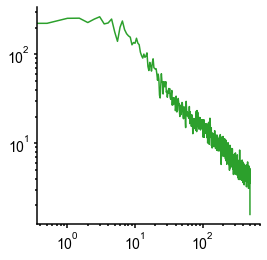

In [197]:
plt.loglog(freqs, psd_o, 'C3')

### Do inference and draw posterior samples.

In [188]:
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((10000,), x=x_o)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

### Visualize posterior samples and ground-truth parameter values.

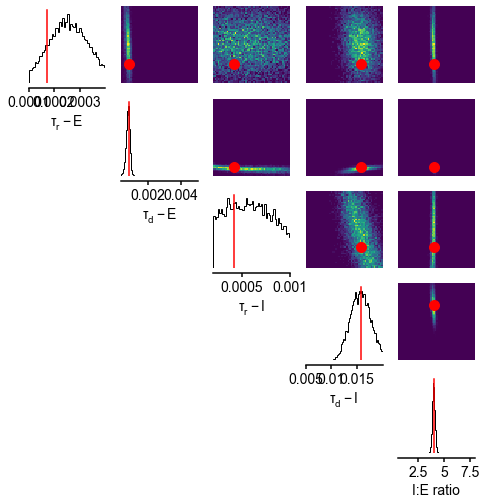

In [195]:
param_names = [r'$\tau_r-E$',r'$\tau_d-E$',r'$\tau_r-I$',r'$\tau_d-I$',r'I:E ratio']
# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=prior_bounds, figsize=(8, 8), labels=param_names,
    points=[theta_o], points_colors=['r']
)

### Simulate and visualize predictive simulation PSDs and FOOOF features.

In [204]:
predictive_lfps = [simulate_ei(ps) for ps in posterior_samples.numpy()[:500]]
# Compute PSDs
freqs, predictive_psds = signal.welch(predictive_lfps, fs=fs, nperseg=nperseg, noverlap=fs, window='hamming')
predictive_samples = fooof_and_extract(freqs, predictive_psds)

Running FOOOFGroup across 500 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



(0.5, 300)

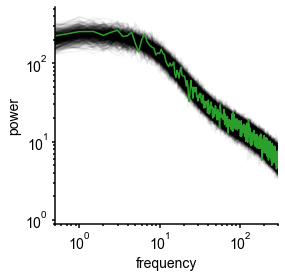

In [208]:
plt.loglog(freqs, predictive_psds.T, 'C0', alpha=0.05);
plt.loglog(freqs, psd_o, 'C3')
plt.xlabel('frequency'); plt.ylabel('power');
plt.xlim([0.5,300])

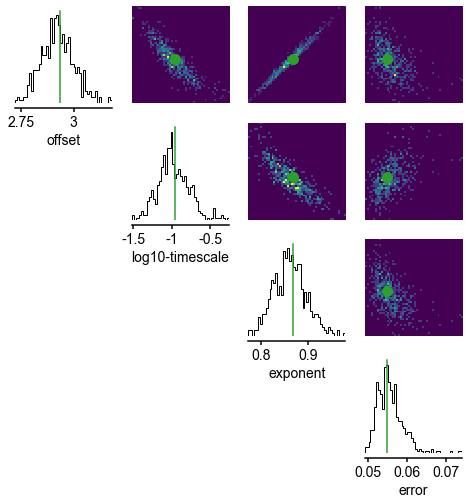

In [209]:
# plot posterior samples
_ = analysis.pairplot(
    predictive_samples, figsize=(8, 8), labels=feature_names,
    points=[torch.Tensor(x_o[0])], points_colors=['C3'],
)